# Caricamento dataset

In [2]:
import torchaudio

train = torchaudio.datasets.LIBRISPEECH(root="./", url="train-clean-100", download=True)
val = torchaudio.datasets.LIBRISPEECH(root="./", url="dev-clean", download=True)
test = torchaudio.datasets.LIBRISPEECH(root="./", url="test-clean", download=True)

100%|██████████| 5.95G/5.95G [07:39<00:00, 13.9MB/s]
100%|██████████| 322M/322M [00:24<00:00, 13.7MB/s]
100%|██████████| 331M/331M [00:26<00:00, 13.0MB/s]


In [3]:
import os

def get_speaker_labels(root_dir):
    speaker_files = []
    labels = []
    count_speakers = 0

    for speaker_id in os.listdir(root_dir):  # Each folder is a speaker
        speaker_path = os.path.join(root_dir, speaker_id)
        count_speakers += 1
        if os.path.isdir(speaker_path):
            for chapter in os.listdir(speaker_path):
                chapter_path = os.path.join(speaker_path, chapter)

                if os.path.isdir(chapter_path):
                    for file in os.listdir(chapter_path):
                        if file.endswith(".flac"):  # LibriSpeech uses FLAC format
                            file_path = os.path.join(chapter_path, file)
                            speaker_files.append(file_path)
                            labels.append(speaker_id)  # Speaker label
    print(f"Number of speakers: {count_speakers}")
    return speaker_files, labels

In [4]:
train_root = "./LibriSpeech/train-clean-100"
val_root = "./LibriSpeech/dev-clean"
test_root = "./LibriSpeech/test-clean"

train_audio_files, train_speaker_labels = get_speaker_labels(train_root)
val_audio_files, val_speaker_labels = get_speaker_labels(val_root)
test_audio_files, test_speaker_labels = get_speaker_labels(test_root)

print(f"Number of training samples: {len(train_audio_files)}")
print(f"Number of validation samples: {len(val_audio_files)}")
print(f"Number of testing samples: {len(test_audio_files)}")

Number of speakers: 251
Number of speakers: 40
Number of speakers: 40
Number of training samples: 28539
Number of validation samples: 2703
Number of testing samples: 2620


In [5]:
import os
from collections import defaultdict

def parse_speaker_metadata(metadata_path):
    """Parsa il file SPEAKERS.TXT e ritorna un dizionario speaker_id -> gender."""
    speaker_gender = {}
    with open(metadata_path, 'r') as f:
        for line in f:
            if line.startswith(';') or not line.strip():
                continue
            parts = line.strip().split('|')
            if len(parts) >= 2:
                speaker_id = parts[0].strip()
                gender = parts[1].strip().lower()
                speaker_gender[speaker_id] = gender
    return speaker_gender

def create_speakers_dict(librispeech_root):
    """
    Scansiona tutte le subset di LibriSpeech e ritorna un unico dizionario speaker_id -> {sex, audio_paths}
    """
    metadata_file = os.path.join(librispeech_root, "SPEAKERS.TXT")
    speaker_gender = parse_speaker_metadata(metadata_file)
    print(len(speaker_gender))

    speakers_dict = defaultdict(lambda: {'sex': None, 'audio_paths': []})

    # Cartelle subset da analizzare
    subsets = ['train-clean-100', 'dev-clean', 'test-clean']

    for subset in subsets:
        subset_path = os.path.join(librispeech_root, subset)
        print(subset_path)
        if not os.path.exists(subset_path):
            continue

        for speaker_id in os.listdir(subset_path):
            speaker_path = os.path.join(subset_path, speaker_id)
            if not os.path.isdir(speaker_path):
                continue

            for chapter_id in os.listdir(speaker_path):
                chapter_path = os.path.join(speaker_path, chapter_id)
                if not os.path.isdir(chapter_path):
                    continue

                for file in os.listdir(chapter_path):
                    if file.endswith(".flac"):
                        file_path = os.path.join(chapter_path, file)
                        speakers_dict[speaker_id]['audio_paths'].append(file_path)

            if speakers_dict[speaker_id]['sex'] is None:
                speakers_dict[speaker_id]['sex'] = speaker_gender.get(speaker_id, "unknown")

    return dict(speakers_dict)


In [6]:
lib_path = "./LibriSpeech"  # modifica con il path corretto
speakers = create_speakers_dict(lib_path)
print(f"Numero speaker trovati: {len(speakers)}")

2484
./LibriSpeech/train-clean-100
./LibriSpeech/dev-clean
./LibriSpeech/test-clean
Numero speaker trovati: 331


In [7]:
# Top 10 male speakers by number of audio_paths
top_male_speakers = sorted(
    [(k, v) for k, v in speakers.items() if v['sex'] == 'm'],
    key=lambda x: len(x[1]['audio_paths']),
    reverse=True
)[:10]

# Top 10 female speakers by number of audio_paths
top_female_speakers = sorted(
    [(k, v) for k, v in speakers.items() if v['sex'] == 'f'],
    key=lambda x: len(x[1]['audio_paths']),
    reverse=True
)[:10]


In [8]:
for speaker_id, speaker_info in top_male_speakers:
    print(f"Speaker ID: {speaker_id}")
    print(f"Gender: {speaker_info['sex']}")
    print(f"Number of audio files: {len(speaker_info['audio_paths'])}")
    print("-" * 30)

for speaker_id, speaker_info in top_female_speakers:
    print(f"Speaker ID: {speaker_id}")
    print(f"Gender: {speaker_info['sex']}")
    print(f"Number of audio files: {len(speaker_info['audio_paths'])}")
    print("-" * 30)

Speaker ID: 4014
Gender: m
Number of audio files: 165
------------------------------
Speaker ID: 8063
Gender: m
Number of audio files: 155
------------------------------
Speaker ID: 27
Gender: m
Number of audio files: 138
------------------------------
Speaker ID: 1867
Gender: m
Number of audio files: 137
------------------------------
Speaker ID: 118
Gender: m
Number of audio files: 137
------------------------------
Speaker ID: 7190
Gender: m
Number of audio files: 131
------------------------------
Speaker ID: 1455
Gender: m
Number of audio files: 131
------------------------------
Speaker ID: 4406
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 2289
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 1081
Gender: m
Number of audio files: 130
------------------------------
Speaker ID: 211
Gender: f
Number of audio files: 166
------------------------------
Speaker ID: 730
Gender: f
Number of audio files: 161
----------------

In [9]:
top_3_male_speakers = top_male_speakers[:5]
top_3_female_speakers = top_female_speakers[:5]

In [10]:
import random

selected_speakers = top_3_male_speakers + top_3_female_speakers

speaker_split_data = {}

# Populate the speaker_split_data dictionary
for speaker_id, speaker_info in selected_speakers:
    all_audio_paths = speaker_info['audio_paths']
    total_files = len(all_audio_paths)
    num_test_files = max(1, int(total_files * 0.1)) # splitting al 10%

    # Shuffle the files to ensure random split
    random.shuffle(all_audio_paths)

    # Split into train and test sets
    test_files = all_audio_paths[:num_test_files]
    train_files = all_audio_paths[num_test_files:]

    speaker_split_data[speaker_id] = {
        'train': train_files,
        'test': test_files
    }

In [11]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_mfcc(audio_path, n_mfcc=20, frame_length_ms=25, frame_hop_ms=10):
    """
    Computes and plots MFCCs for a single audio file using STFT with window and hop in milliseconds.

    Args:
    - audio_path (str): Path to the audio file.
    - n_mfcc (int): Number of MFCCs to extract.
    - frame_length_ms (int): Frame length in milliseconds.
    - frame_hop_ms (int): Hop length in milliseconds.
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)

    # Convert ms to samples
    frame_length = int(sr * frame_length_ms / 1000)
    hop_length = int(sr * frame_hop_ms / 1000)

    print(f"Frame Length: {frame_length} samples")
    print(f"Hop Length: {hop_length} samples")

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    print(f"MFCC shape: {mfccs.shape}")

    # Plot the MFCCs
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=hop_length, cmap='viridis')
    plt.colorbar(label="MFCC Coefficients")
    plt.title("MFCCs of the Audio File")
    plt.xlabel("Time (seconds)")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram(audio_path, frame_length_ms=40, frame_hop_ms=10):
    """
    Computes and plots a log-magnitude spectrogram to visualize formants,
    using STFT with frame length and hop size specified in milliseconds.

    Args:
    - audio_path (str): Path to the audio file.
    - frame_length_ms (int): STFT window size in milliseconds.
    - frame_hop_ms (int): Hop size in milliseconds.
    """
    y, sr = librosa.load(audio_path, sr=None)  # Load audio

    # Convert milliseconds to samples
    frame_size = int(sr * frame_length_ms / 1000)
    hop_length = int(sr * frame_hop_ms / 1000)

    # Compute STFT and log magnitude
    stft = np.abs(librosa.stft(y, n_fft=frame_size, hop_length=hop_length))
    log_spectrogram = librosa.amplitude_to_db(stft, ref=np.max)

    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='inferno')
    plt.colorbar(label="Log Magnitude (dB)")
    plt.title("Log-Magnitude Spectrogram (Formants Visualization)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_with_pitch(audio_path, frame_length_ms=40, hop_length_ms=10, fmin=50, fmax=300):
    """
    Computes and plots the log-magnitude spectrogram and overlays pitch (F0),
    helpful for distinguishing male vs female voices.

    Args:
    - audio_path (str): Path to audio file.
    - frame_length_ms (int): Frame length in milliseconds.
    - hop_length_ms (int): Hop size in milliseconds.
    - fmin (float): Minimum pitch to detect.
    - fmax (float): Maximum pitch to detect.
    """
    y, sr = librosa.load(audio_path, sr=None)

    # Convert ms to samples
    frame_length = int(sr * frame_length_ms / 1000)
    hop_length = int(sr * hop_length_ms / 1000)

    # Compute STFT
    stft = np.abs(librosa.stft(y, n_fft=frame_length, hop_length=hop_length)) # prendo comunque il valore assoluto
    log_spectrogram = librosa.amplitude_to_db(stft, ref=np.max)

    # Compute pitch using librosa's YIN algorithm ---> libreria nativa di librosa
    f0 = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, frame_length=frame_length, hop_length=hop_length)

    # Plot
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='inferno')
    times = librosa.frames_to_time(np.arange(len(f0)), sr=sr, hop_length=hop_length)
    plt.plot(times, f0, label='Estimated Pitch (F0)', color='cyan', linewidth=2)
    plt.colorbar(label='Log Magnitude (dB)')
    plt.title("Spectrogram with Estimated Pitch (F0)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Frequency (Hz)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # Return pitch values for further use
    return f0

In [14]:
# Print the structure and number of files for each speaker
for speaker_id, split_data in speaker_split_data.items():
    print(f"Speaker ID: {speaker_id}")

# Speaker ID: 4014
# Speaker ID: 8063
# Speaker ID: 27
# Speaker ID: 118
# Speaker ID: 1867
# Speaker ID: 211
# Speaker ID: 730
# Speaker ID: 2989
# Speaker ID: 4195
# Speaker ID: 125

Speaker ID: 4014
Speaker ID: 8063
Speaker ID: 27
Speaker ID: 1867
Speaker ID: 118
Speaker ID: 211
Speaker ID: 730
Speaker ID: 2989
Speaker ID: 4195
Speaker ID: 125


Speaker ID: 4014


<ipython-input-13-5a045f44d26f>:29: UserWarning: With fmin=50.000, sr=16000 and frame_length=640, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=50.000 or frame_length=641.
  f0 = librosa.yin(y, fmin=fmin, fmax=fmax, sr=sr, frame_length=frame_length, hop_length=hop_length)


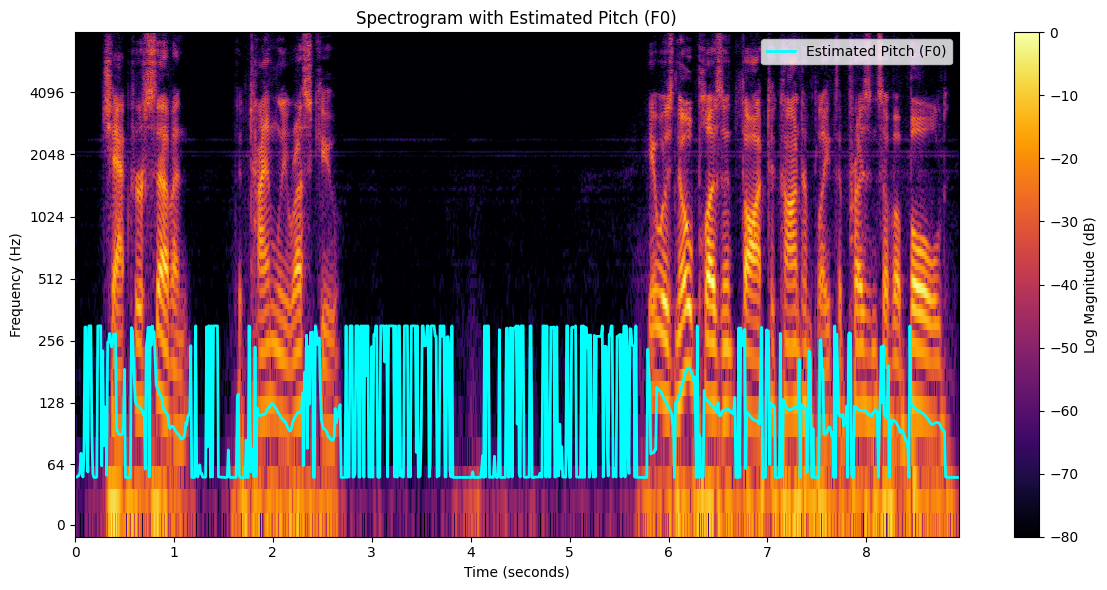

Likely Female Voice (Mean Pitch: 135 Hz)
Speaker ID: 8063


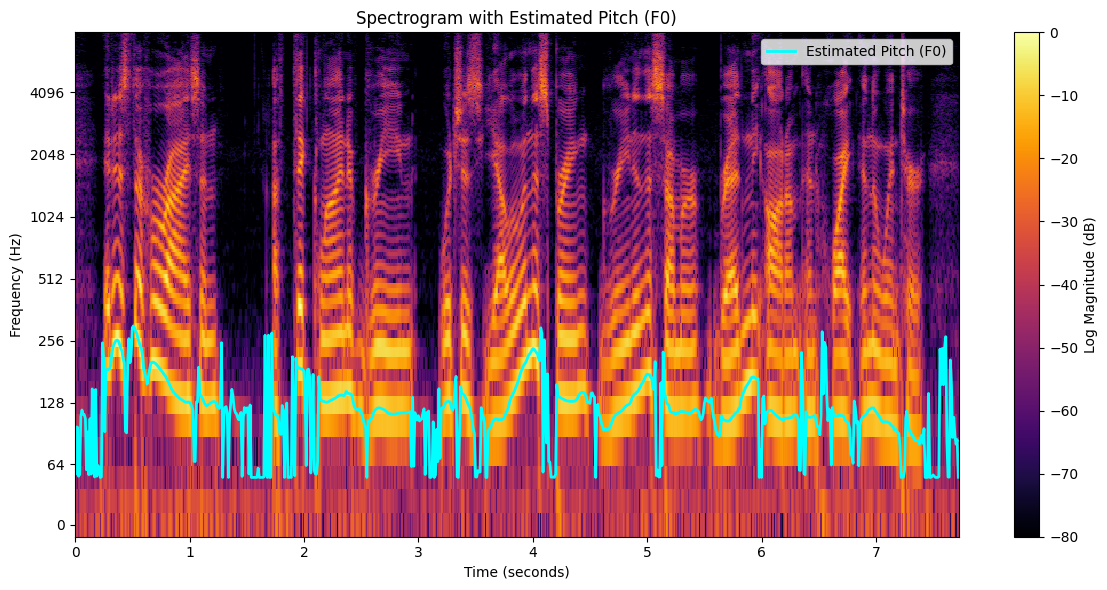

Likely Female Voice (Mean Pitch: 124 Hz)
Speaker ID: 27


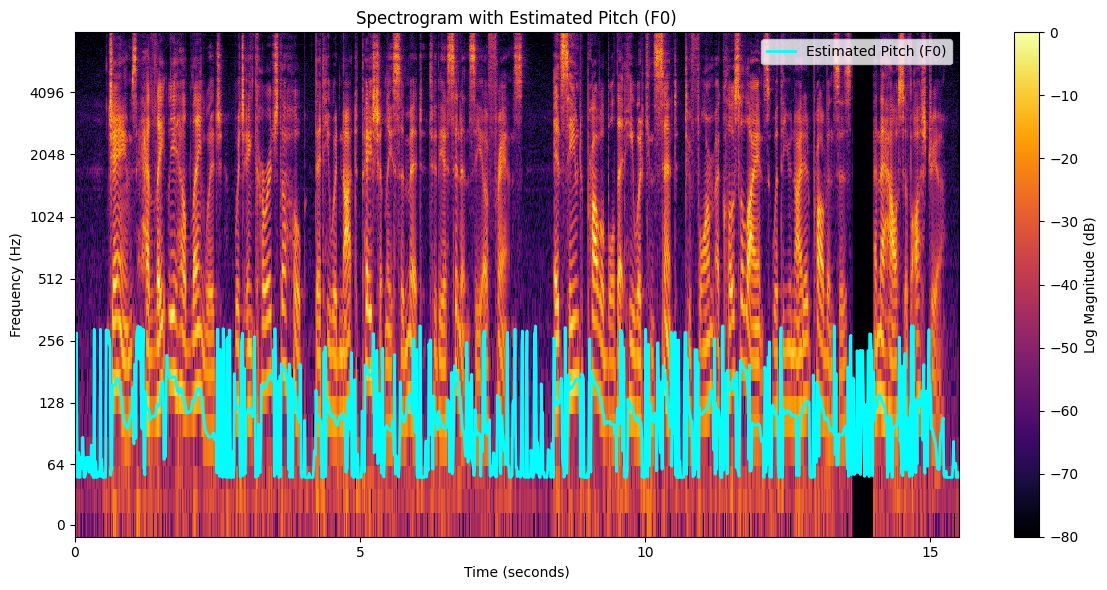

Likely Male Voice (Mean Pitch: 115 Hz)
Speaker ID: 1867


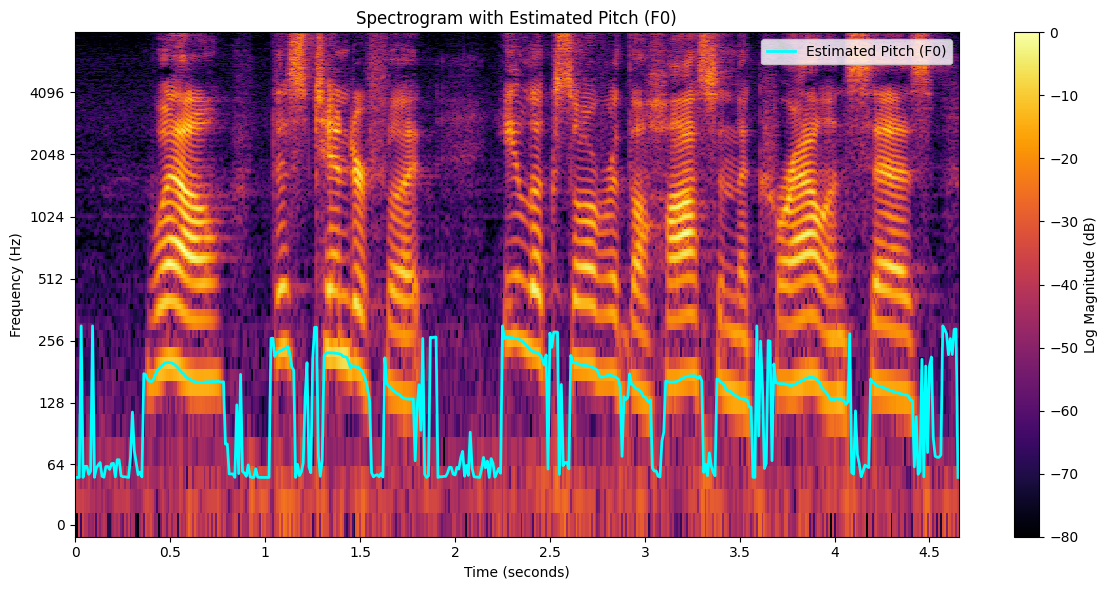

Likely Female Voice (Mean Pitch: 141 Hz)
Speaker ID: 118


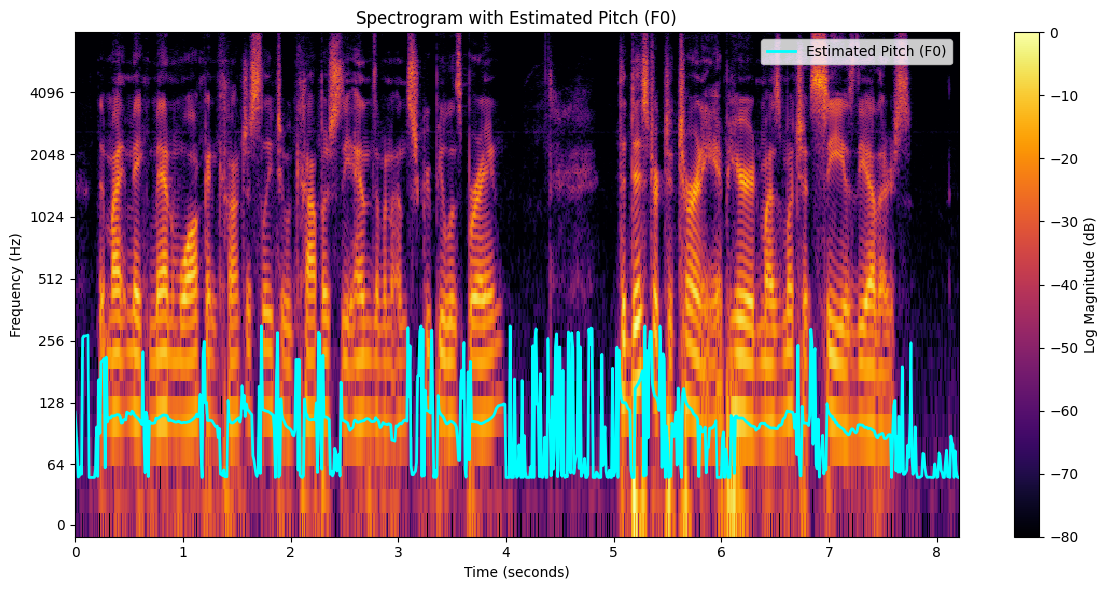

Likely Male Voice (Mean Pitch: 105 Hz)
Speaker ID: 211


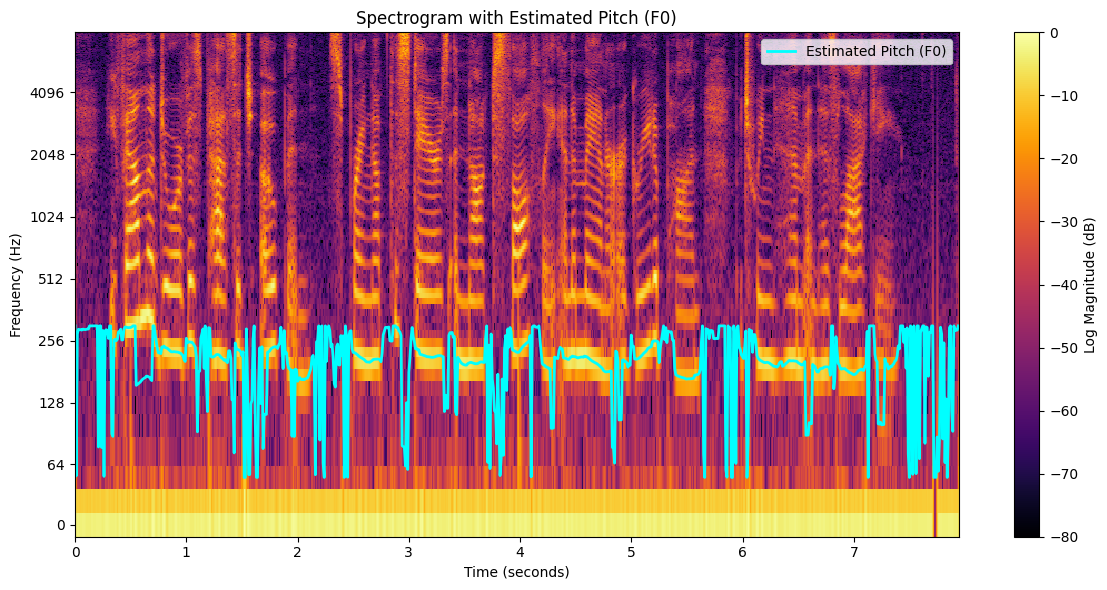

Likely Female Voice (Mean Pitch: 210 Hz)
Speaker ID: 730


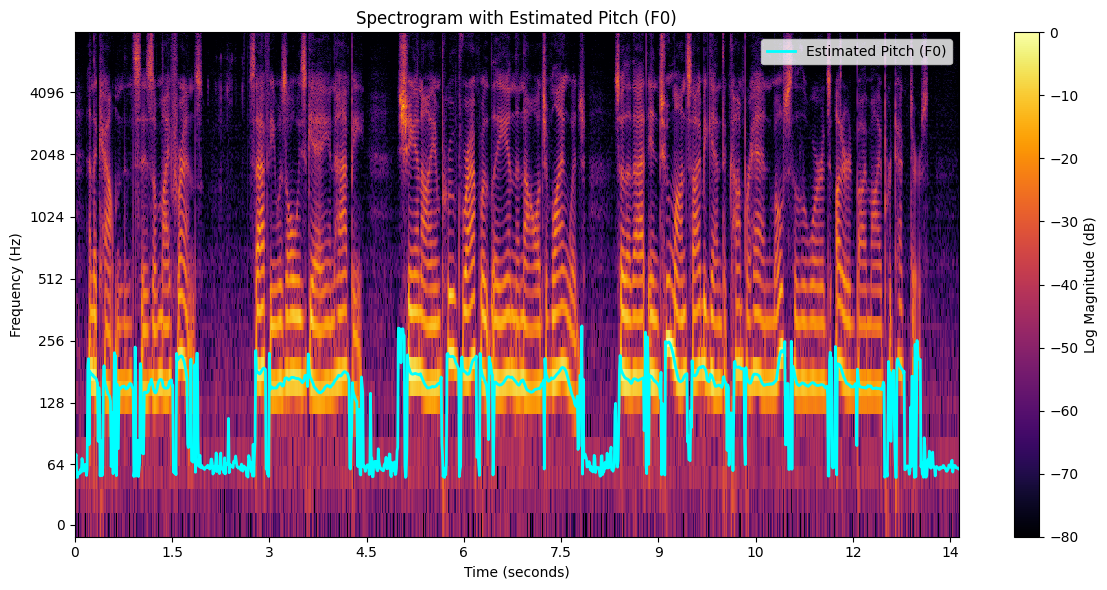

Likely Female Voice (Mean Pitch: 137 Hz)
Speaker ID: 2989


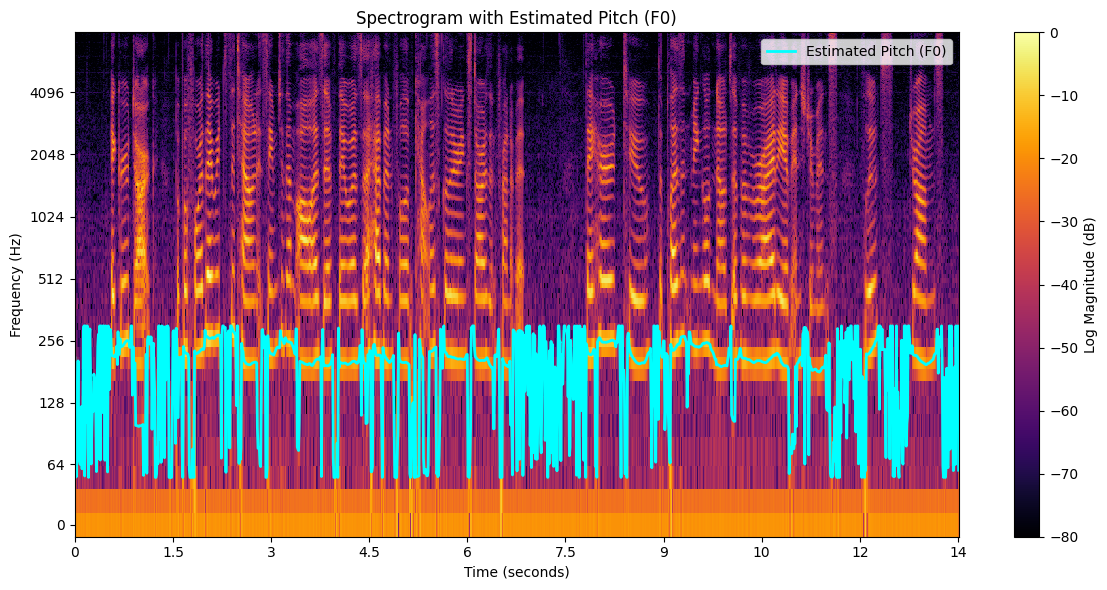

Likely Female Voice (Mean Pitch: 194 Hz)
Speaker ID: 4195


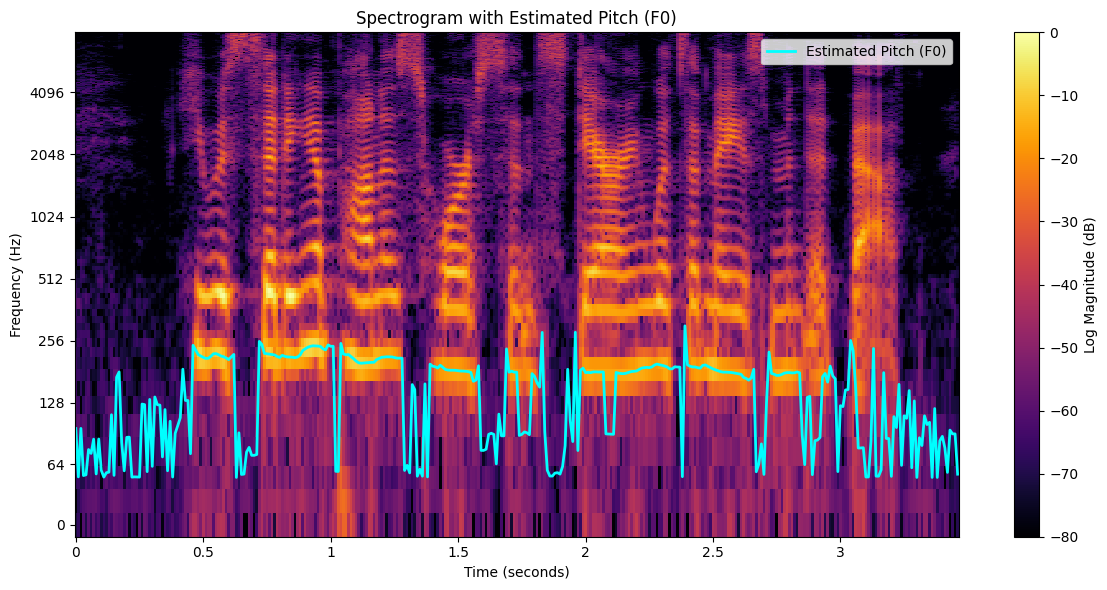

Likely Female Voice (Mean Pitch: 148 Hz)
Speaker ID: 125


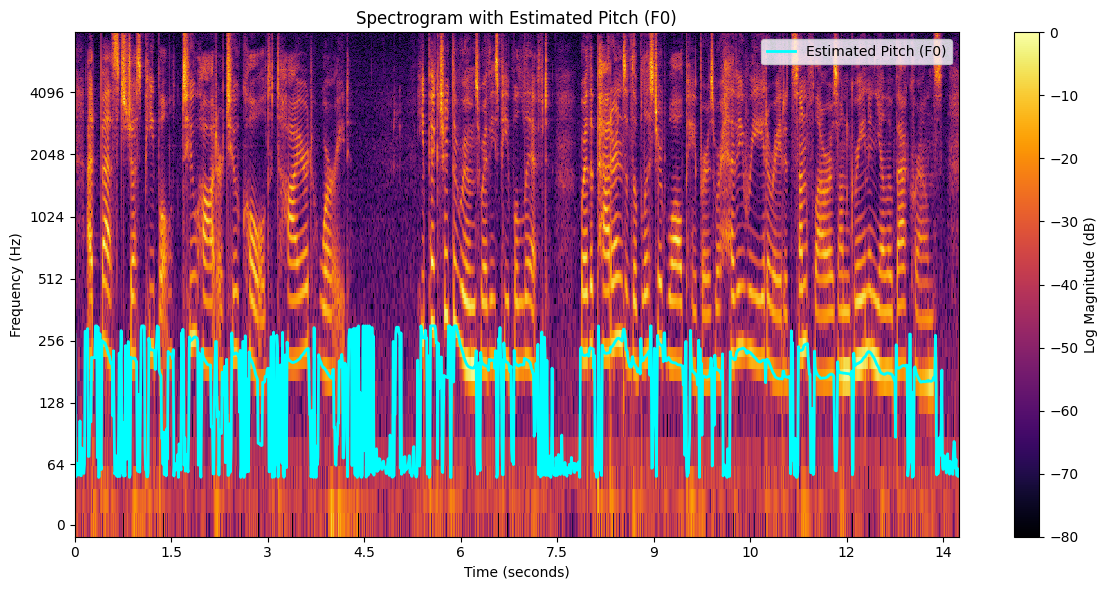

Likely Female Voice (Mean Pitch: 165 Hz)


In [ ]:
for speaker_id, split_data in speaker_split_data.items():
    print(f"Speaker ID: {speaker_id}")
    f0 = plot_spectrogram_with_pitch(speaker_split_data[speaker_id]['train'][0])
    mean_pitch = np.nanmean(f0)
    if mean_pitch < 120:
        print("Likely Male Voice (Mean Pitch:", round(mean_pitch), "Hz)")
    else:
        print("Likely Female Voice (Mean Pitch:", round(mean_pitch), "Hz)")



In [16]:
def compute_mfcc(audio_path, n_mfcc=25, frame_length_ms=25, frame_hop_ms=10):
    """
    Questa funzione permette di calcolare gli MFCC per una singola traccia audio effettuando analisi STFT
    In questa versione usiamo i semplici MFCC come embedding
    Args:
    - audio_path (str): Path to the audio file.
    - n_mfcc (int): Number of MFCCs to extract.
    - frame_length_ms (int): Frame length in milliseconds.
    - frame_hop_ms (int): Hop length in milliseconds.
    Returns:
    - mfccs (numpy.ndarray): MFCCs for the audio file.
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=None)

    # Convert ms to samples
    frame_length = int(sr * frame_length_ms / 1000)
    hop_length = int(sr * frame_hop_ms / 1000)

    # print(f"Frame Length: {frame_length} samples")
    # print(f"Hop Length: {hop_length} samples")

    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length)
    # print(f"MFCC shape: {mfccs.shape}")

    return mfccs

def compute_max_shape_mfcc(audio_paths):
    """
    Dal momento che estraiamo 13 mfcc per ogni singola traccia audio, devo capire però quanti frames sto considerando per
    fare padding con il frame più lungo.
    """
    max_shape = (0, 0)  # (Frames, MFCCs)
    for audio_path in audio_paths:
        mfccs = compute_mfcc(audio_path) # (n_mfccs, frames)
        if mfccs.shape[1] > max_shape[1]:
            max_shape = (mfccs.shape[1], mfccs.shape[0])
    return max_shape

In [17]:
audio_paths = []
for speaker_id, split_data in speaker_split_data.items():
    audio_paths.extend(split_data['train'])
print(len(audio_paths))

1348


In [ ]:
compute_max_shape_mfcc(audio_paths=audio_paths)

(570, 25)

In [19]:
# prompt: salva lo speaker split data

import pickle

with open('speaker_split_data.pkl', 'wb') as f:
    pickle.dump(speaker_split_data, f)

print("speaker_split_data saved successfully as speaker_split_data.pkl")

speaker_split_data saved successfully as speaker_split_data.pkl


In [20]:
# prompt: adesso scrivi per LOADlo spaker split data

with open('speaker_split_data.pkl', 'rb') as f:
    loaded_speaker_split_data = pickle.load(f)

print("speaker_split_data loaded successfully from speaker_split_data.pkl")
print(f"Loaded data keys: {loaded_speaker_split_data.keys()}")

speaker_split_data loaded successfully from speaker_split_data.pkl
Loaded data keys: dict_keys(['4014', '8063', '27', '1867', '118', '211', '730', '2989', '4195', '125'])


# DNN improved i-vectors

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import zscore
from IPython.display import Audio

In [22]:
class MFCCExtractor:
    def __init__(self, n_mfcc=20, win_length=0.025, hop_length=0.010):
        self.n_mfcc = n_mfcc
        self.win_length_s = win_length
        self.hop_length_s = hop_length

    def extract(self, audio_path):
        y, sr = librosa.load(audio_path, sr=None)
        win_length = int(sr * self.win_length_s)
        hop_length = int(sr * self.hop_length_s)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc, n_fft=win_length, hop_length=hop_length)
        return mfcc.T

In [ ]:
#nell'articolo dichiarano di usare un VAD Voice Activity Detector basato su una soglia di energia
class AudioEmbeddingPreparer:
    def energy_vad(self, mfcc):
        energy = mfcc[:, 0]
        threshold = np.percentile(energy, 30)
        # nell'articolo non specificano quanto vale la soglia, andrebbe valutato in termini di cross validazione
        # tuttavia possiamo notare come effettivamente il dataset sia ben strutturato, quindi basterebbe una soglia minima come questa
        return mfcc[energy > threshold]

    def prepare(self, mfcc_features):
        # filtered = self.energy_vad(mfcc_features) # filtro in base al VAD
        filtered = mfcc_features # per la I-DNN non dobbiamo applicare VAD
        # restituisco solo le features che hanno un falore superoire ad una certa soglia, filtrando i coefficienti
        return zscore(filtered, axis=0)

Implementiamo la rete descritta anche nell'articolo

In [24]:
class SpeakerEmbeddingDNN(nn.Module):
    def __init__(self, input_dim=20, emb_dim=300, num_classes=1000):
        super().__init__()
        self.frame_layers = nn.Sequential(
            nn.Linear(input_dim * 5, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )
        self.segment_pooling = lambda x: torch.cat([x.mean(dim=1), x.std(dim=1)], dim=1)
        self.seg_layers = nn.Sequential(
            nn.Linear(512 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, emb_dim)
        )
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B, T, D = x.shape
        x = x.unfold(1, 5, 1).reshape(B, -1, D * 5)
        frame_out = self.frame_layers(x)
        pooled = self.segment_pooling(frame_out)
        emb = self.seg_layers(pooled)
        logits = self.classifier(emb)
        return logits, emb

In [26]:
audio_paths = []
for speaker_id, split_data in speaker_split_data.items():
    audio_paths.extend(split_data['train'])
print(len(audio_paths))

1348


## Utilizzo delle classi

In [28]:
mfcc_extractor = MFCCExtractor()
preparer = AudioEmbeddingPreparer()

In [29]:
# prova delle classi
audio_path = audio_paths[0]
features = preparer.prepare(mfcc_extractor.extract(audio_path))
features.shape

(626, 20)

In [30]:
def exctract_embeddings(audio_path, max_frames=1600):
    """
    Questa funzione permette di calcolare gli MFCC per una singola traccia audio effettuando analisi STFT
    In questa versione usiamo i semplici MFCC come embedding
    Args:
    - audio_path (str): Path to the audio file.
    - n_mfcc (int): Number of MFCCs to extract.
    - frame_length_ms (int): Frame length in milliseconds.
    - frame_hop_ms (int): Hop length in milliseconds.
    """
    features = preparer.prepare(mfcc_extractor.extract(audio_path))  # (frames, n_mfcc)
    # Pad or truncate to fixed max_frames
    if features.shape[0] < max_frames:
        pad_width = max_frames - features.shape[0]
        features = np.pad(features, ((0, pad_width), (0, 0)), mode='constant')
    else:
        features = features[:max_frames, :]  # truncate
    return torch.tensor(features, dtype=torch.float32)  # Shape: (Frames, MFCCs)

In [31]:
audio_path = audio_paths[0]
features = exctract_embeddings(audio_path)
features.shape

torch.Size([1600, 20])

In [ ]:
# Load dataset and prepare training & test data
def load_data(speaker_audio_paths, max_frames=1600):
    X_train, y_train, X_test, y_test = [], [], [], []
    speaker_to_index = {speaker: idx for idx, speaker in enumerate(speaker_audio_paths.keys())}
    for speaker_id, data in speaker_audio_paths.items():
        # Process training samples
        for audio_path in data["train"]:
            features_tensor = exctract_embeddings(audio_path, max_frames=max_frames)
            X_train.append(features_tensor)
            y_train.append(speaker_to_index[speaker_id])
        # Process test sample (single file per speaker)
        for audio_path in data["test"]:
            features_tensor = exctract_embeddings(audio_path, max_frames=max_frames)
            X_test.append(features_tensor)
            y_test.append(speaker_to_index[speaker_id])
    return (
        torch.stack(X_train), torch.tensor(y_train, dtype=torch.long),
        torch.stack(X_test), torch.tensor(y_test, dtype=torch.long),
        speaker_to_index
    )

In [33]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

X_train, y_train, X_test, y_test, speaker_to_index = load_data(speaker_split_data)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1348, 1600, 20])
torch.Size([1348])
torch.Size([144, 1600, 20])
torch.Size([144])


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Initialize model
# input dim sono gli embeddings di feature input, quindi il numero di mfcc
model = SpeakerEmbeddingDNN(input_dim=X_train.shape[2], num_classes=len(speaker_to_index))

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Parametri per early stopping
patience = 30  # Numero di epoche senza miglioramenti prima di fermarsi
best_f1 = 0
counter = 0
best_model_state = None

In [36]:
print(f"Model: {model}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Model: SpeakerEmbeddingDNN(
  (frame_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
  )
  (seg_layers): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=300, bias=True)
  )
  (classifier): Linear(in_features=300, out_features=10, bias=True)
)
Number of parameters: 1258734


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
from torch.utils.data import Dataset, DataLoader

class SpeakerDataset(Dataset):
    def __init__(self, speaker_audio_paths, max_frames=1600):
        self.samples = []
        self.labels = []
        self.speaker_to_index = {speaker: idx for idx, speaker in enumerate(speaker_audio_paths.keys())}
        for speaker, data in speaker_audio_paths.items():
            label = self.speaker_to_index[speaker]
            for split in ["train", "test"]:
                for audio_path in data[split]:
                    features = exctract_embeddings(audio_path, max_frames=max_frames)
                    self.samples.append(features)
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [40]:
# Then create separate train/test datasets:
train_samples = []
train_labels = []
test_samples = []
test_labels = []
for speaker, data in speaker_split_data.items():
    label = speaker_to_index[speaker]
    for audio_path in data["train"]:
        train_samples.append(exctract_embeddings(audio_path, max_frames=1600))
        train_labels.append(label)
    for audio_path in data["test"]:
        test_samples.append(exctract_embeddings(audio_path, max_frames=1600))
        test_labels.append(label)

In [41]:
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_samples), torch.tensor(train_labels))
test_dataset = torch.utils.data.TensorDataset(torch.stack(test_samples), torch.tensor(test_labels))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeakerEmbeddingDNN(input_dim=X_train.shape[2], num_classes=len(speaker_to_index))
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

best_f1 = 0.0
counter = 0
patience = 30

In [ ]:
from tqdm import tqdm

for epoch in tqdm(range(100), desc="Training"):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item() * X_batch.size(0)

            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    avg_val_loss = total_val_loss / len(test_loader.dataset)
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    accuracy = accuracy_score(all_labels.numpy(), all_preds.numpy())
    f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="weighted")

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy*100:.2f}%, F1: {f1:.4f}")

    if f1 >= best_f1:
        best_f1 = f1
        print(f"New best F1: {best_f1:.4f} - saving model")
        best_model_state = model.state_dict()
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break

torch.save(best_model_state, "best_model_dnn.pth")
print(f"Best model saved with F1: {best_f1:.4f}")

Training:   1%|          | 1/100 [00:02<03:50,  2.33s/it]

Epoch 1, Train Loss: 2.2991, Val Loss: 2.2732, Accuracy: 31.94%, F1: 0.1751
New best F1: 0.1751 - saving model


Training:   2%|▏         | 2/100 [00:04<03:45,  2.30s/it]

Epoch 2, Train Loss: 2.0023, Val Loss: 1.3617, Accuracy: 57.64%, F1: 0.4942
New best F1: 0.4942 - saving model


Training:   3%|▎         | 3/100 [00:06<03:45,  2.33s/it]

Epoch 3, Train Loss: 1.0041, Val Loss: 0.7065, Accuracy: 79.17%, F1: 0.7849
New best F1: 0.7849 - saving model


Training:   4%|▍         | 4/100 [00:09<03:46,  2.36s/it]

Epoch 4, Train Loss: 0.5837, Val Loss: 0.4664, Accuracy: 88.89%, F1: 0.8867
New best F1: 0.8867 - saving model


Training:   5%|▌         | 5/100 [00:11<03:43,  2.35s/it]

Epoch 5, Train Loss: 0.3916, Val Loss: 0.4086, Accuracy: 86.81%, F1: 0.8613


Training:   6%|▌         | 6/100 [00:14<03:39,  2.34s/it]

Epoch 6, Train Loss: 0.2878, Val Loss: 0.4076, Accuracy: 87.50%, F1: 0.8719


Training:   7%|▋         | 7/100 [00:16<03:36,  2.33s/it]

Epoch 7, Train Loss: 0.2422, Val Loss: 0.2073, Accuracy: 94.44%, F1: 0.9420
New best F1: 0.9420 - saving model


Training:   8%|▊         | 8/100 [00:18<03:33,  2.32s/it]

Epoch 8, Train Loss: 0.2012, Val Loss: 0.2120, Accuracy: 93.06%, F1: 0.9304


Training:   9%|▉         | 9/100 [00:21<03:34,  2.36s/it]

Epoch 9, Train Loss: 0.1877, Val Loss: 0.1196, Accuracy: 97.22%, F1: 0.9723
New best F1: 0.9723 - saving model


Training:  10%|█         | 10/100 [00:23<03:35,  2.39s/it]

Epoch 10, Train Loss: 0.1389, Val Loss: 0.1049, Accuracy: 95.83%, F1: 0.9584


Training:  11%|█         | 11/100 [00:25<03:31,  2.38s/it]

Epoch 11, Train Loss: 0.1194, Val Loss: 0.1783, Accuracy: 94.44%, F1: 0.9426


Training:  12%|█▏        | 12/100 [00:28<03:27,  2.36s/it]

Epoch 12, Train Loss: 0.1113, Val Loss: 0.0891, Accuracy: 97.22%, F1: 0.9723


Training:  13%|█▎        | 13/100 [00:30<03:24,  2.36s/it]

Epoch 13, Train Loss: 0.0897, Val Loss: 0.0689, Accuracy: 97.92%, F1: 0.9793
New best F1: 0.9793 - saving model


Training:  14%|█▍        | 14/100 [00:32<03:22,  2.35s/it]

Epoch 14, Train Loss: 0.0699, Val Loss: 0.0581, Accuracy: 98.61%, F1: 0.9860
New best F1: 0.9860 - saving model


Training:  15%|█▌        | 15/100 [00:35<03:20,  2.36s/it]

Epoch 15, Train Loss: 0.0987, Val Loss: 0.0843, Accuracy: 97.22%, F1: 0.9721


Training:  16%|█▌        | 16/100 [00:37<03:18,  2.36s/it]

Epoch 16, Train Loss: 0.0690, Val Loss: 0.0550, Accuracy: 97.92%, F1: 0.9791


Training:  17%|█▋        | 17/100 [00:40<03:16,  2.36s/it]

Epoch 17, Train Loss: 0.0520, Val Loss: 0.0480, Accuracy: 99.31%, F1: 0.9930
New best F1: 0.9930 - saving model


Training:  18%|█▊        | 18/100 [00:42<03:13,  2.36s/it]

Epoch 18, Train Loss: 0.0448, Val Loss: 0.0693, Accuracy: 97.92%, F1: 0.9793


Training:  19%|█▉        | 19/100 [00:44<03:11,  2.37s/it]

Epoch 19, Train Loss: 0.0365, Val Loss: 0.0537, Accuracy: 98.61%, F1: 0.9861


Training:  20%|██        | 20/100 [00:47<03:09,  2.37s/it]

Epoch 20, Train Loss: 0.0395, Val Loss: 0.0589, Accuracy: 97.22%, F1: 0.9723


Training:  21%|██        | 21/100 [00:49<03:06,  2.36s/it]

Epoch 21, Train Loss: 0.0417, Val Loss: 0.0520, Accuracy: 97.22%, F1: 0.9723


Training:  22%|██▏       | 22/100 [00:51<03:03,  2.36s/it]

Epoch 22, Train Loss: 0.1371, Val Loss: 0.0574, Accuracy: 97.92%, F1: 0.9791


Training:  23%|██▎       | 23/100 [00:54<03:00,  2.35s/it]

Epoch 23, Train Loss: 0.0373, Val Loss: 0.0442, Accuracy: 97.92%, F1: 0.9793


Training:  24%|██▍       | 24/100 [00:56<02:57,  2.34s/it]

Epoch 24, Train Loss: 0.0233, Val Loss: 0.0404, Accuracy: 97.92%, F1: 0.9793


Training:  25%|██▌       | 25/100 [00:58<02:54,  2.33s/it]

Epoch 25, Train Loss: 0.0196, Val Loss: 0.0399, Accuracy: 98.61%, F1: 0.9860


Training:  26%|██▌       | 26/100 [01:01<02:52,  2.33s/it]

Epoch 26, Train Loss: 0.0169, Val Loss: 0.0397, Accuracy: 98.61%, F1: 0.9861


Training:  27%|██▋       | 27/100 [01:03<02:49,  2.32s/it]

Epoch 27, Train Loss: 0.0168, Val Loss: 0.0369, Accuracy: 98.61%, F1: 0.9860


Training:  28%|██▊       | 28/100 [01:05<02:46,  2.32s/it]

Epoch 28, Train Loss: 0.0159, Val Loss: 0.0433, Accuracy: 98.61%, F1: 0.9860


Training:  29%|██▉       | 29/100 [01:07<02:43,  2.31s/it]

Epoch 29, Train Loss: 0.0138, Val Loss: 0.0441, Accuracy: 97.92%, F1: 0.9793


Training:  30%|███       | 30/100 [01:10<02:41,  2.30s/it]

Epoch 30, Train Loss: 0.0135, Val Loss: 0.0418, Accuracy: 97.92%, F1: 0.9793


Training:  31%|███       | 31/100 [01:12<02:38,  2.30s/it]

Epoch 31, Train Loss: 0.0115, Val Loss: 0.0388, Accuracy: 97.92%, F1: 0.9793


Training:  32%|███▏      | 32/100 [01:14<02:36,  2.30s/it]

Epoch 32, Train Loss: 0.0092, Val Loss: 0.0508, Accuracy: 98.61%, F1: 0.9861


Training:  33%|███▎      | 33/100 [01:17<02:33,  2.30s/it]

Epoch 33, Train Loss: 0.0113, Val Loss: 0.0553, Accuracy: 97.92%, F1: 0.9791


Training:  34%|███▍      | 34/100 [01:19<02:31,  2.29s/it]

Epoch 34, Train Loss: 0.0197, Val Loss: 0.0482, Accuracy: 97.92%, F1: 0.9793


Training:  35%|███▌      | 35/100 [01:21<02:28,  2.29s/it]

Epoch 35, Train Loss: 0.0091, Val Loss: 0.0381, Accuracy: 97.22%, F1: 0.9724


Training:  36%|███▌      | 36/100 [01:24<02:26,  2.29s/it]

Epoch 36, Train Loss: 0.0082, Val Loss: 0.0377, Accuracy: 97.92%, F1: 0.9793


Training:  37%|███▋      | 37/100 [01:26<02:24,  2.29s/it]

Epoch 37, Train Loss: 0.0063, Val Loss: 0.0478, Accuracy: 97.92%, F1: 0.9791


Training:  38%|███▊      | 38/100 [01:28<02:21,  2.29s/it]

Epoch 38, Train Loss: 0.0050, Val Loss: 0.0390, Accuracy: 97.92%, F1: 0.9793


Training:  39%|███▉      | 39/100 [01:30<02:19,  2.29s/it]

Epoch 39, Train Loss: 0.0044, Val Loss: 0.0355, Accuracy: 97.92%, F1: 0.9793


Training:  40%|████      | 40/100 [01:33<02:17,  2.29s/it]

Epoch 40, Train Loss: 0.0045, Val Loss: 0.0414, Accuracy: 97.92%, F1: 0.9791


Training:  41%|████      | 41/100 [01:35<02:19,  2.37s/it]

Epoch 41, Train Loss: 0.0046, Val Loss: 0.0482, Accuracy: 98.61%, F1: 0.9861


Training:  42%|████▏     | 42/100 [01:38<02:18,  2.38s/it]

Epoch 42, Train Loss: 0.0046, Val Loss: 0.0396, Accuracy: 97.92%, F1: 0.9793


Training:  43%|████▎     | 43/100 [01:40<02:14,  2.36s/it]

Epoch 43, Train Loss: 0.0036, Val Loss: 0.0438, Accuracy: 97.92%, F1: 0.9793


Training:  44%|████▍     | 44/100 [01:42<02:11,  2.34s/it]

Epoch 44, Train Loss: 0.0034, Val Loss: 0.0418, Accuracy: 97.92%, F1: 0.9793


Training:  45%|████▌     | 45/100 [01:45<02:08,  2.34s/it]

Epoch 45, Train Loss: 0.0033, Val Loss: 0.0395, Accuracy: 98.61%, F1: 0.9860


Training:  46%|████▌     | 46/100 [01:47<02:05,  2.33s/it]

Epoch 46, Train Loss: 0.0035, Val Loss: 0.0410, Accuracy: 97.92%, F1: 0.9793


Training:  47%|████▋     | 47/100 [01:49<02:05,  2.38s/it]

Epoch 47, Train Loss: 0.0028, Val Loss: 0.0408, Accuracy: 97.92%, F1: 0.9793


Training:  48%|████▊     | 48/100 [01:52<02:03,  2.38s/it]

Epoch 48, Train Loss: 0.0027, Val Loss: 0.0492, Accuracy: 97.92%, F1: 0.9793


Training:  49%|████▉     | 49/100 [01:54<02:00,  2.37s/it]

Epoch 49, Train Loss: 0.0024, Val Loss: 0.0491, Accuracy: 97.92%, F1: 0.9793


Training:  50%|█████     | 50/100 [01:56<01:57,  2.35s/it]

Epoch 50, Train Loss: 0.0024, Val Loss: 0.0437, Accuracy: 97.92%, F1: 0.9793


Training:  51%|█████     | 51/100 [01:59<01:54,  2.34s/it]

Epoch 51, Train Loss: 0.0037, Val Loss: 0.0546, Accuracy: 97.92%, F1: 0.9793


Training:  52%|█████▏    | 52/100 [02:01<01:52,  2.34s/it]

Epoch 52, Train Loss: 0.0022, Val Loss: 0.0484, Accuracy: 97.92%, F1: 0.9793


Training:  53%|█████▎    | 53/100 [02:03<01:49,  2.33s/it]

Epoch 53, Train Loss: 0.0019, Val Loss: 0.0456, Accuracy: 97.92%, F1: 0.9793


Training:  54%|█████▍    | 54/100 [02:06<01:48,  2.36s/it]

Epoch 54, Train Loss: 0.0018, Val Loss: 0.0436, Accuracy: 97.92%, F1: 0.9793


Training:  55%|█████▌    | 55/100 [02:08<01:46,  2.36s/it]

Epoch 55, Train Loss: 0.0016, Val Loss: 0.0456, Accuracy: 97.92%, F1: 0.9793


Training:  56%|█████▌    | 56/100 [02:11<01:43,  2.36s/it]

Epoch 56, Train Loss: 0.0014, Val Loss: 0.0454, Accuracy: 98.61%, F1: 0.9860


Training:  57%|█████▋    | 57/100 [02:13<01:41,  2.35s/it]

Epoch 57, Train Loss: 0.0014, Val Loss: 0.0416, Accuracy: 97.92%, F1: 0.9793


Training:  58%|█████▊    | 58/100 [02:15<01:38,  2.34s/it]

Epoch 58, Train Loss: 0.0014, Val Loss: 0.0467, Accuracy: 97.92%, F1: 0.9793


Training:  59%|█████▉    | 59/100 [02:18<01:35,  2.34s/it]

Epoch 59, Train Loss: 0.0012, Val Loss: 0.0421, Accuracy: 98.61%, F1: 0.9860


Training:  60%|██████    | 60/100 [02:20<01:33,  2.33s/it]

Epoch 60, Train Loss: 0.0012, Val Loss: 0.0448, Accuracy: 97.92%, F1: 0.9793


Training:  61%|██████    | 61/100 [02:22<01:30,  2.33s/it]

Epoch 61, Train Loss: 0.0012, Val Loss: 0.0460, Accuracy: 97.92%, F1: 0.9793


Training:  62%|██████▏   | 62/100 [02:24<01:28,  2.33s/it]

Epoch 62, Train Loss: 0.0011, Val Loss: 0.0496, Accuracy: 97.92%, F1: 0.9791


Training:  63%|██████▎   | 63/100 [02:27<01:26,  2.33s/it]

Epoch 63, Train Loss: 0.0015, Val Loss: 0.0482, Accuracy: 97.92%, F1: 0.9793


Training:  64%|██████▍   | 64/100 [02:29<01:23,  2.33s/it]

Epoch 64, Train Loss: 0.0011, Val Loss: 0.0447, Accuracy: 97.92%, F1: 0.9793


Training:  65%|██████▌   | 65/100 [02:31<01:21,  2.32s/it]

Epoch 65, Train Loss: 0.0010, Val Loss: 0.0457, Accuracy: 97.92%, F1: 0.9793


Training:  66%|██████▌   | 66/100 [02:34<01:18,  2.32s/it]

Epoch 66, Train Loss: 0.0009, Val Loss: 0.0476, Accuracy: 97.92%, F1: 0.9793


Training:  67%|██████▋   | 67/100 [02:36<01:16,  2.32s/it]

Epoch 67, Train Loss: 0.0008, Val Loss: 0.0509, Accuracy: 97.92%, F1: 0.9793


Training:  68%|██████▊   | 68/100 [02:38<01:14,  2.32s/it]

Epoch 68, Train Loss: 0.0008, Val Loss: 0.0492, Accuracy: 98.61%, F1: 0.9860


Training:  69%|██████▉   | 69/100 [02:41<01:11,  2.32s/it]

Epoch 69, Train Loss: 0.0008, Val Loss: 0.0466, Accuracy: 97.92%, F1: 0.9793


Training:  70%|███████   | 70/100 [02:43<01:09,  2.32s/it]

Epoch 70, Train Loss: 0.0007, Val Loss: 0.0465, Accuracy: 97.92%, F1: 0.9793


Training:  71%|███████   | 71/100 [02:45<01:07,  2.32s/it]

Epoch 71, Train Loss: 0.0007, Val Loss: 0.0538, Accuracy: 97.92%, F1: 0.9793


Training:  72%|███████▏  | 72/100 [02:48<01:04,  2.31s/it]

Epoch 72, Train Loss: 0.0007, Val Loss: 0.0465, Accuracy: 97.92%, F1: 0.9793


Training:  73%|███████▎  | 73/100 [02:50<01:02,  2.32s/it]

Epoch 73, Train Loss: 0.0007, Val Loss: 0.0457, Accuracy: 97.92%, F1: 0.9793


Training:  74%|███████▍  | 74/100 [02:52<01:00,  2.32s/it]

Epoch 74, Train Loss: 0.0006, Val Loss: 0.0490, Accuracy: 97.92%, F1: 0.9793


Training:  75%|███████▌  | 75/100 [02:55<00:57,  2.32s/it]

Epoch 75, Train Loss: 0.0006, Val Loss: 0.0519, Accuracy: 97.92%, F1: 0.9793


Training:  76%|███████▌  | 76/100 [02:57<00:55,  2.31s/it]

Epoch 76, Train Loss: 0.0006, Val Loss: 0.0498, Accuracy: 97.92%, F1: 0.9791


Training:  77%|███████▋  | 77/100 [02:59<00:53,  2.31s/it]

Epoch 77, Train Loss: 0.0005, Val Loss: 0.0480, Accuracy: 97.92%, F1: 0.9793


Training:  78%|███████▊  | 78/100 [03:02<00:50,  2.32s/it]

Epoch 78, Train Loss: 0.0005, Val Loss: 0.0534, Accuracy: 97.92%, F1: 0.9793


Training:  79%|███████▉  | 79/100 [03:04<00:48,  2.32s/it]

Epoch 79, Train Loss: 0.0005, Val Loss: 0.0494, Accuracy: 97.92%, F1: 0.9793


Training:  80%|████████  | 80/100 [03:06<00:46,  2.32s/it]

Epoch 80, Train Loss: 0.0004, Val Loss: 0.0468, Accuracy: 97.92%, F1: 0.9793


Training:  81%|████████  | 81/100 [03:09<00:43,  2.32s/it]

Epoch 81, Train Loss: 0.0004, Val Loss: 0.0464, Accuracy: 97.92%, F1: 0.9793


Training:  82%|████████▏ | 82/100 [03:11<00:41,  2.32s/it]

Epoch 82, Train Loss: 0.0004, Val Loss: 0.0480, Accuracy: 97.92%, F1: 0.9793


Training:  83%|████████▎ | 83/100 [03:13<00:39,  2.32s/it]

Epoch 83, Train Loss: 0.0004, Val Loss: 0.0494, Accuracy: 97.92%, F1: 0.9793


Training:  84%|████████▍ | 84/100 [03:15<00:37,  2.32s/it]

Epoch 84, Train Loss: 0.0004, Val Loss: 0.0473, Accuracy: 97.92%, F1: 0.9793


Training:  85%|████████▌ | 85/100 [03:18<00:34,  2.32s/it]

Epoch 85, Train Loss: 0.0004, Val Loss: 0.0488, Accuracy: 97.92%, F1: 0.9793


Training:  86%|████████▌ | 86/100 [03:20<00:32,  2.32s/it]

Epoch 86, Train Loss: 0.0004, Val Loss: 0.0490, Accuracy: 97.92%, F1: 0.9793


Training:  87%|████████▋ | 87/100 [03:22<00:30,  2.32s/it]

Epoch 87, Train Loss: 0.0004, Val Loss: 0.0450, Accuracy: 97.92%, F1: 0.9793


Training:  88%|████████▊ | 88/100 [03:25<00:27,  2.32s/it]

Epoch 88, Train Loss: 0.0004, Val Loss: 0.0446, Accuracy: 97.92%, F1: 0.9793


Training:  89%|████████▉ | 89/100 [03:27<00:25,  2.32s/it]

Epoch 89, Train Loss: 0.0003, Val Loss: 0.0545, Accuracy: 97.92%, F1: 0.9793


Training:  90%|█████████ | 90/100 [03:29<00:23,  2.32s/it]

Epoch 90, Train Loss: 0.0003, Val Loss: 0.0469, Accuracy: 97.92%, F1: 0.9793


Training:  91%|█████████ | 91/100 [03:32<00:21,  2.34s/it]

Epoch 91, Train Loss: 0.0003, Val Loss: 0.0527, Accuracy: 97.92%, F1: 0.9793


Training:  92%|█████████▏| 92/100 [03:34<00:19,  2.39s/it]

Epoch 92, Train Loss: 0.0003, Val Loss: 0.0476, Accuracy: 97.92%, F1: 0.9793


Training:  93%|█████████▎| 93/100 [03:37<00:17,  2.43s/it]

Epoch 93, Train Loss: 0.0003, Val Loss: 0.0504, Accuracy: 97.92%, F1: 0.9793


Training:  94%|█████████▍| 94/100 [03:39<00:14,  2.44s/it]

Epoch 94, Train Loss: 0.0003, Val Loss: 0.0490, Accuracy: 97.92%, F1: 0.9793


Training:  95%|█████████▌| 95/100 [03:42<00:12,  2.41s/it]

Epoch 95, Train Loss: 0.0004, Val Loss: 0.0516, Accuracy: 97.92%, F1: 0.9793


Training:  96%|█████████▌| 96/100 [03:44<00:09,  2.41s/it]

Epoch 96, Train Loss: 0.0003, Val Loss: 0.0519, Accuracy: 97.92%, F1: 0.9793


Training:  97%|█████████▋| 97/100 [03:46<00:07,  2.41s/it]

Epoch 97, Train Loss: 0.0002, Val Loss: 0.0501, Accuracy: 97.92%, F1: 0.9793


Training:  98%|█████████▊| 98/100 [03:49<00:04,  2.39s/it]

Epoch 98, Train Loss: 0.0002, Val Loss: 0.0499, Accuracy: 97.92%, F1: 0.9793


Training:  99%|█████████▉| 99/100 [03:51<00:02,  2.41s/it]

Epoch 99, Train Loss: 0.0002, Val Loss: 0.0476, Accuracy: 97.92%, F1: 0.9793


Training: 100%|██████████| 100/100 [03:54<00:00,  2.34s/it]

Epoch 100, Train Loss: 0.0002, Val Loss: 0.0539, Accuracy: 97.92%, F1: 0.9793
Best model saved with F1: 0.9930


In [ ]:
# Load the best model state
model = SpeakerEmbeddingDNN(input_dim=X_train.shape[2], num_classes=len(speaker_to_index))
model.load_state_dict(torch.load("best_model_dnn.pth"))
model.eval()  # Set the model to evaluation mode

# Calculate predictions on the test set
with torch.no_grad():
    logits, _ = model(X_test)
    y_preds = logits.argmax(dim=1)

# y_test contains the true labels

# Print the true and predicted labels
print("\nTrue Test Labels (y_test):")
print(y_test.numpy())

print("\nPredicted Test Labels (y_preds):")
print(y_preds.numpy())


True Test Labels (y_test):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9]

Predicted Test Labels (y_preds):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 0 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 6 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9]


In [53]:
# Compute Accuracy
accuracy = accuracy_score(y_test.numpy(), y_preds.numpy())
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# You can add other multiclass metrics here
from sklearn.metrics import classification_report

print("\nClassification Report:")
# The target_names argument can make the report more readable
print(classification_report(y_test.numpy(), y_preds.numpy(), target_names=[str(i) for i in speaker_to_index.keys()]))

Test Accuracy: 97.92%

Classification Report:
              precision    recall  f1-score   support

        4014       0.94      1.00      0.97        16
        8063       1.00      1.00      1.00        15
          27       1.00      1.00      1.00        13
        1867       1.00      0.92      0.96        13
         118       1.00      0.92      0.96        13
         211       0.89      1.00      0.94        16
         730       1.00      0.94      0.97        16
        2989       1.00      1.00      1.00        15
        4195       1.00      1.00      1.00        14
         125       1.00      1.00      1.00        13

    accuracy                           0.98       144
   macro avg       0.98      0.98      0.98       144
weighted avg       0.98      0.98      0.98       144



# Speaker Verification

In [79]:
all_speaker_ids = set(speakers.keys()) # insieme di speaker ID
selected_ids = set(speaker_split_data.keys()) # insieme di speaker selezionati
impostor_ids = list(all_speaker_ids - selected_ids) # insieme di impostori

In [80]:
print(len(all_speaker_ids))
print(len(selected_ids))
print(len(impostor_ids))

331
10
321


In [81]:
import random

num_impostors = 10
files_per_impostor = 10

unauthorized_audio_paths = []
unauthorized_speaker_labels = []

for spk_id in random.sample(impostor_ids, min(num_impostors, len(impostor_ids))):
    paths = speakers[spk_id]['audio_paths']
    if paths:
        selected = paths[:files_per_impostor]
        unauthorized_audio_paths.extend(selected)
        unauthorized_speaker_labels.extend([spk_id] * len(selected))

print(f"Extracted {len(unauthorized_audio_paths)} audio files from {len(set(unauthorized_speaker_labels))} impostor speakers.")

Extracted 100 audio files from 10 impostor speakers.


In [82]:
speaker_split_data_paths = list(speaker_split_data.values())
speaker_split_data_paths = [item for sublist in speaker_split_data_paths for item in sublist]

Adesso per ogni utente non autorizzato (impostore) devo estrarre gli embeddings come abbiamo descritto nel progetto

In [83]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import librosa
import torch.nn as nn
import torch.optim as optim

In [120]:
model = SpeakerEmbeddingDNN(input_dim=X_train.shape[2], num_classes=len(speaker_to_index))
# Load the best model state from the saved file
try:
    model.load_state_dict(torch.load("best_model_dnn.pth"))
    print("Loaded best_model_dnn.pth")
except FileNotFoundError:
    print("best_model_dnn.pth not found. Ensure you have trained and saved the model.")
    # You might want to handle this error appropriately, perhaps re-train or exit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Set the model to evaluation mode

X_train_embs = []
X_genuine_embs = []
X_impostors_embs = []

Loaded best_model_dnn.pth


In [122]:
train_audio_paths = []
for speaker_id, data in speaker_split_data.items():
    train_audio_paths.extend(data['train'])

genuine_audio_paths = []
for speaker_id, data in speaker_split_data.items():
    genuine_audio_paths.extend(data['test'])

In [123]:
print(len(train_audio_paths))
print(len(genuine_audio_paths))
print(len(unauthorized_audio_paths))

1348
144
100


Dobbiamo processarli

In [124]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to extract embeddings from model
def extract_embeddings_dnn(audio_path, model, device, max_frames=1600):
    """
    Extract embeddings from the network
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad():
        features = exctract_embeddings(audio_path, max_frames=max_frames)
        features = features.to(device)
        _, embs = model(features.unsqueeze(0))
    return embs.cpu().numpy()

In [125]:
for path in tqdm(train_audio_paths, desc="Extracting train embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_train_embs.append(embedding)

for path in tqdm(genuine_audio_paths, desc="Extracting genuine embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_genuine_embs.append(embedding)

for path in tqdm(unauthorized_audio_paths, desc="Extracting impostor embeddings"):
  embedding = extract_embeddings_dnn(path, model, device)
  X_impostors_embs.append(embedding)

Extracting impostor embeddings: 100%|██████████| 100/100 [00:03<00:00, 25.13it/s]


In [126]:
X_train_embs[0].shape # perfetto (300 è la dimensione corretta)

(1, 300)

In [127]:
X_train_embs = np.array(X_train_embs)
X_genuine_embs = np.array(X_genuine_embs)
X_impostors_embs = np.array(X_impostors_embs)

print(X_train_embs.shape)
print(X_genuine_embs.shape)
print(X_impostors_embs.shape)

(1348, 1, 300)
(144, 1, 300)
(100, 1, 300)


In [128]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
import numpy as np

'''
usiamo un modello GMM perchè comunque vorremmo capire quanto gli impostori si discostano da quelli reali.
'''

class PLDABackend:
    def __init__(self, n_components=2, covariance_type='full'):
        self.gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type)
        self.is_fitted = False

    def fit(self, X):
        # Optionally normalize embeddings before fitting
        X_reshaped = X.reshape(X.shape[0], -1)
        X_norm = normalize(X_reshaped)
        self.gmm.fit(X_norm)
        self.is_fitted = True

    def score(self, X):
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before scoring.")
        X_reshaped = X.reshape(X.shape[0], -1)
        X_norm = normalize(X_reshaped)
        # Returns log likelihoods of samples under the model
        return self.gmm.score_samples(X_norm)

    def score_pair(self, X1, X2):
        # Score pairs by difference in likelihoods or some heuristic,
        # but generally scoring pairs in this GMM setup isn't trivial.
        # Instead, you score embeddings independently and compare scores.
        scores1 = self.score(X1)
        scores2 = self.score(X2)
        # Example: similarity could be difference or average of scores,
        # but typically you'd score enrollment and test separately.
        return scores1, scores2

In [129]:
backend = PLDABackend()
backend.fit(X_train_embs)  # Fit only X_train samples

genuine_scores = backend.score(X_genuine_embs) # compute on test and impostor
impostor_scores = backend.score(X_impostors_embs)

In [105]:
# Compute EER and threshold as you already do
from sklearn.metrics import roc_curve

y_true = np.concatenate([np.ones(len(genuine_scores)), np.zeros(len(impostor_scores))])
y_scores = np.concatenate([genuine_scores, impostor_scores])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
fnr = 1 - tpr
eer_idx = np.nanargmin(np.abs(fnr - fpr))
eer = fpr[eer_idx]
eer_threshold = thresholds[eer_idx]

print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {eer_threshold:.4f}")

EER: 0.1600
Threshold at EER: 1735.0257


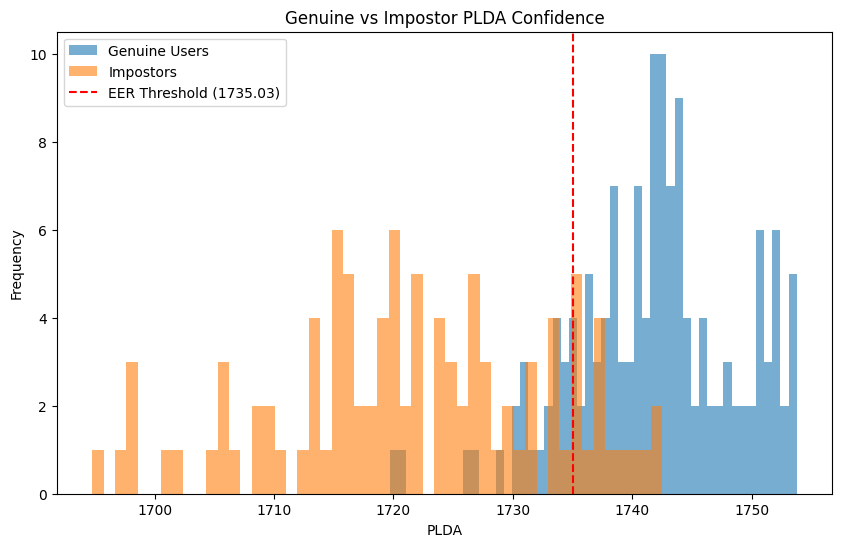

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(genuine_scores, bins=50, alpha=0.6, label="Genuine Users")
plt.hist(impostor_scores, bins=50, alpha=0.6, label="Impostors")
plt.axvline(eer_threshold, color="red", linestyle="--", label=f"EER Threshold ({eer_threshold:.2f})")
plt.xlabel("PLDA")
plt.ylabel("Frequency")
plt.title("Genuine vs Impostor PLDA Confidence")
plt.legend()
plt.show()